In [208]:
import torch

import os
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import models

from PIL import Image


In [209]:
device = "cuda:0"
class Normalize(nn.Module):
    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = models.resnet50(pretrained=True).to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [210]:
class Helper():
    def __init__(self, model, thresh_p=0.5, device="cuda"):
        self.model =nn.Sequential(
            Normalize(),
            model)

        self.device = device
        self.model.to(device)
        self.thresh_p = thresh_p
        self.inter_features = []
        self.inter_features = []
        self.register_hooks()
        
    def register_hooks(self):
        def forward_hook_fn(module, inputs, outputs):
            self.inter_features += [outputs]
            
        def backward_hook_fn(module, grad_in, grad_out):
            features = self.inter_features.pop()
            grad = grad_in[0]
            tmp = grad * features
            thresh = torch.kthvalue(
                tmp.flatten(),
                k=int(self.thresh_p*len(tmp.flatten())+1)
            )[0]
#             print("thresh", thresh)
            mask = (tmp > thresh)
            return (grad_in[0]*mask,)
        
        modules = list(self.model.named_children())
        for i, module in enumerate(self.model.modules()):
            if isinstance(module, nn.ReLU):
                module.register_forward_hook(forward_hook_fn)
                module.register_backward_hook(backward_hook_fn)
                
def input_gradient(helper, img_path):
    img = np.array(Image.open(img_path))
    plt.imshow(img)
    plt.show()
    
    
    img_t = torch.from_numpy(img).permute(2,0,1).unsqueeze(0).to(device).float() / 255.0
    img_t.requires_grad = True
    helper.model(img_t).max().backward()
    grad = img_t.grad.abs()
    grad_img = grad.squeeze().permute(1,2,0).cpu().numpy()*255 
    print(grad.shape)
    plt.imshow(grad_img)
    plt.show()
        
    
    
    
    
    

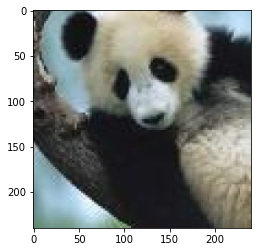

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 240, 240])


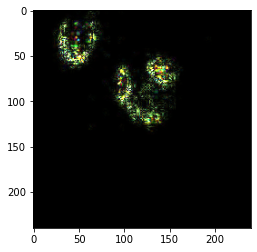

In [211]:
helper = Helper(model, thresh_p=0.99)

img_path = "./data/giant_panda/1.jpg"
input_gradient(helper, img_path)